In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
#Cargar datos
df_model = pd.read_csv('./datos/dataset_para_modelo.csv')
df_model.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,abv
0,-0.365740,1.893255,-1.991031,0.508281,0.062968,0.551172,-0.334256,0.447740,-0.395888,0.733462,6.91
1,-0.631026,0.871423,-0.401300,1.279091,0.076585,0.870546,-0.368587,0.237166,-0.316042,0.632559,6.88
2,-0.365740,1.893255,-1.991031,0.508281,0.062968,0.551172,-0.334256,0.447740,-0.395888,0.733462,6.92
3,0.307395,1.025011,-1.505403,-0.255888,-1.326650,1.966904,-0.704821,1.112036,0.371025,0.216241,7.03
4,-0.730491,1.424105,-1.966777,0.261043,-0.076430,0.088406,-0.044683,0.318661,-0.049580,0.304575,6.78


In [5]:
# IMPLEMENTACION DE REGRESION LINEAL CON VALIDACION CRUZADA K-FOLD DE DATOS SIN PCA

X = df_model.drop(columns='abv')
y = df_model['abv']

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Modelo base: Regresión Lineal
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicción y evaluación en test
y_pred = lr.predict(X_test)
y_pred_lr = lr.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test R²: {r2_test:.3f}")

# Validación cruzada (k=5)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse = cross_val_score(lr, X, y, cv=cv, scoring='neg_mean_squared_error')
r2_cv = cross_val_score(lr, X, y, cv=cv, scoring='r2')
rmse_cv = np.sqrt(-neg_mse)
print(f"CV RMSE (media ± std): {rmse_cv.mean():.3f} ± {rmse_cv.std():.3f}")
print(f"CV R² (media ± std): {r2_cv.mean():.3f} ± {r2_cv.std():.3f}")

Test RMSE: 0.143
Test R²: 0.061
CV RMSE (media ± std): 0.125 ± 0.016
CV R² (media ± std): 0.201 ± 0.113


In [6]:
# IMPLEMENTACION DE REGRESION PLS CON BUSQUEDA DE COMPONENTES OPTIMOS Y VALIDACION CRUZADA K-FOLD

# Definir X e y
X = df_model.drop(columns='abv')
y = df_model['abv']

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Escalado de X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Selección del número óptimo de componentes PLS por CV
n_comps = list(range(1, X_train_scaled.shape[1]+1))
cv = KFold(n_splits=5, shuffle=True, random_state=42)
mse_cv = []

for n in n_comps:
    pls = PLSRegression(n_components=n)
    neg_mse = cross_val_score(pls, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
    mse_cv.append(-neg_mse.mean())

optimal_n = n_comps[int(np.argmin(mse_cv))]
print(f"Componentes óptimos (CV): {optimal_n}")

# Entrenar PLS con número óptimo de componentes
pls_opt = PLSRegression(n_components=optimal_n)
pls_opt.fit(X_train_scaled, y_train)

# Evaluación en test
y_pred = pls_opt.predict(X_test_scaled)
y_pred_pls = pls_opt.predict(X_test_scaled).ravel()
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
print(f"Test RMSE (PLS): {rmse_test:.3f}")
print(f"Test R² (PLS): {r2_test:.3f}")

# Validación cruzada final sobre todo X
pls_final = PLSRegression(n_components=optimal_n)
neg_mse_full = cross_val_score(pls_final, scaler.fit_transform(X), y, cv=cv, scoring='neg_mean_squared_error')
r2_full = cross_val_score(pls_final, scaler.transform(X), y, cv=cv, scoring='r2')
rmse_full = np.sqrt(-neg_mse_full)
print(f"CV RMSE (PLS): {rmse_full.mean():.3f} ± {rmse_full.std():.3f}")
print(f"CV R² (PLS): {r2_full.mean():.3f} ± {r2_full.std():.3f}")

Componentes óptimos (CV): 10
Test RMSE (PLS): 0.143
Test R² (PLS): 0.061
CV RMSE (PLS): 0.125 ± 0.016
CV R² (PLS): 0.201 ± 0.113


In [7]:
#SELECCION DE COMPONENTES OPTIMOS EN PLS MEDIANTE VALIDACION CRUZADA Y EVALUACION EN TEST

# Definir X e y usando df_model ya existente
X = df_model.drop(columns='abv')
y = df_model['abv']

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Selección de n_components entre 1 y 8 mediante CV (5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
n_comps = range(1, 9)
mse_cv = []

for n in n_comps:
    pls = PLSRegression(n_components=n)
    neg_mse = cross_val_score(pls, X_train_scaled, y_train, cv=cv,
                              scoring='neg_mean_squared_error')
    mse_cv.append(-neg_mse.mean())

# Mostrar resultados CV para cada n_components
for n, mse in zip(n_comps, mse_cv):
    print(f"n_components={n}, CV RMSE={np.sqrt(mse):.3f}")

# Definir número óptimo de componentes
optimal_n = n_comps[np.argmin(mse_cv)]
print(f"\nComponente óptimo (mínimo CV RMSE): {optimal_n}")

# Entrenar PLS con n_components=optimal_n y evaluar en test
pls_opt = PLSRegression(n_components=optimal_n)
pls_opt.fit(X_train_scaled, y_train)
y_pred = pls_opt.predict(X_test_scaled)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
print(f"\nTest RMSE (PLS n={optimal_n}): {rmse_test:.3f}")
print(f"Test R² (PLS n={optimal_n}): {r2_test:.3f}")


n_components=1, CV RMSE=0.118
n_components=2, CV RMSE=0.117
n_components=3, CV RMSE=0.117
n_components=4, CV RMSE=0.117
n_components=5, CV RMSE=0.117
n_components=6, CV RMSE=0.117
n_components=7, CV RMSE=0.117
n_components=8, CV RMSE=0.117

Componente óptimo (mínimo CV RMSE): 8

Test RMSE (PLS n=8): 0.143
Test R² (PLS n=8): 0.061


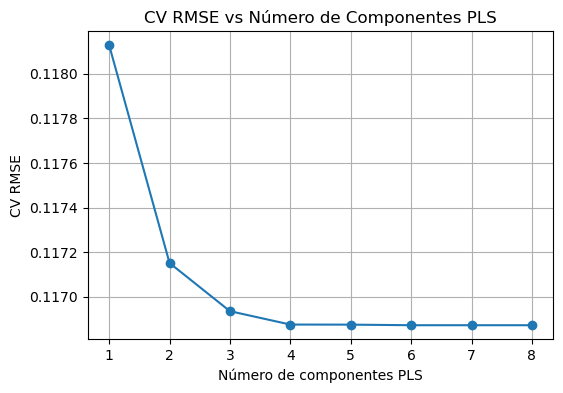

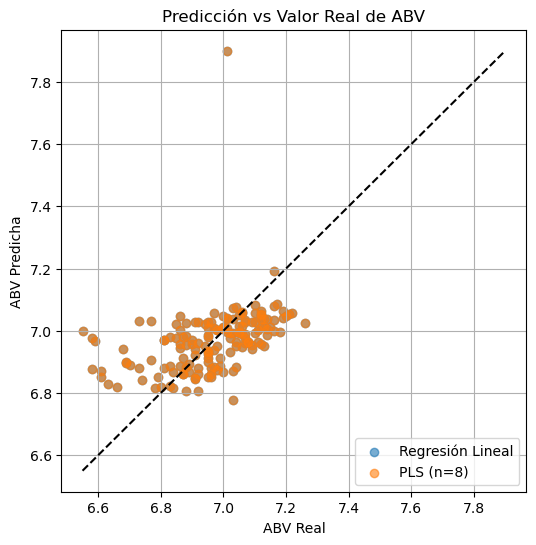

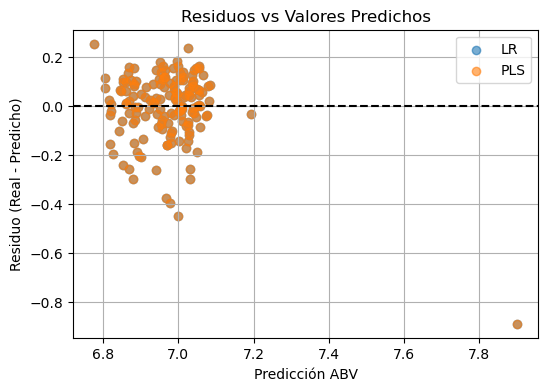

In [8]:
# EVALUACION GRAFICA DE MODELOS: CURVA CV RMSE PLS, PREDICCION VS REAL Y ANALISIS DE RESIDUOS

# Curva CV RMSE vs número de componentes (PLS)
plt.figure(figsize=(6,4))
plt.plot(list(n_comps), np.sqrt(mse_cv), marker='o')
plt.xlabel('Número de componentes PLS')
plt.ylabel('CV RMSE')
plt.title('CV RMSE vs Número de Componentes PLS')
plt.grid(True)
plt.show()

# Scatter Predicción vs Real (ABV) para ambos modelos

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.6, label='Regresión Lineal')
plt.scatter(y_test, y_pred_pls, alpha=0.6, label=f'PLS (n={optimal_n})')
mn, mx = min(y_test.min(), y_pred_lr.min(), y_pred_pls.min()), max(y_test.max(), y_pred_lr.max(), y_pred_pls.max())
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel('ABV Real')
plt.ylabel('ABV Predicha')
plt.title('Predicción vs Valor Real de ABV')
plt.legend()
plt.grid(True)
plt.show()

# Residuals vs Predichos
resid_lr = y_test - y_pred_lr
resid_pls = y_test - y_pred_pls

plt.figure(figsize=(6,4))
plt.scatter(y_pred_lr, resid_lr, alpha=0.6, label='LR')
plt.scatter(y_pred_pls, resid_pls, alpha=0.6, label='PLS')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicción ABV')
plt.ylabel('Residuo (Real - Predicho)')
plt.title('Residuos vs Valores Predichos')
plt.legend()
plt.grid(True)
plt.show()